KNN Classifier Model

Data loading took 0.03 seconds.
Feature preprocessing took 0.01 seconds.
Fitting 5 folds for each of 540 candidates, totalling 2700 fits

Best KNN parameters found:
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNN training with hyperparameter tuning took 31.71 seconds.

Model saved to /Users/mariaprosgaznares/Desktop/Birdify/models/optimized_KNN_model.pkl

Model package saved to /Users/mariaprosgaznares/Desktop/Birdify/models/knn_model_package.pkl

Evaluating Optimized KNN Model:

Evaluation Metrics Summary:
Accuracy: 0.9487
Balanced Accuracy: 0.9487
Matthews Correlation: 0.9477
Cohen's Kappa: 0.9476
AUC (OvR): 0.9867
AUC (OvO): 0.9867
Weighted Avg F1: 0.9474
Macro Avg F1: 0.9474

Detailed Classification Report:
                            precision    recall  f1-score   support

               Andean Guan       0.96      0.87      0.91        30
          Band-tailed Guan       0.85      0.77      0.81        30
            Barred Tinamou    

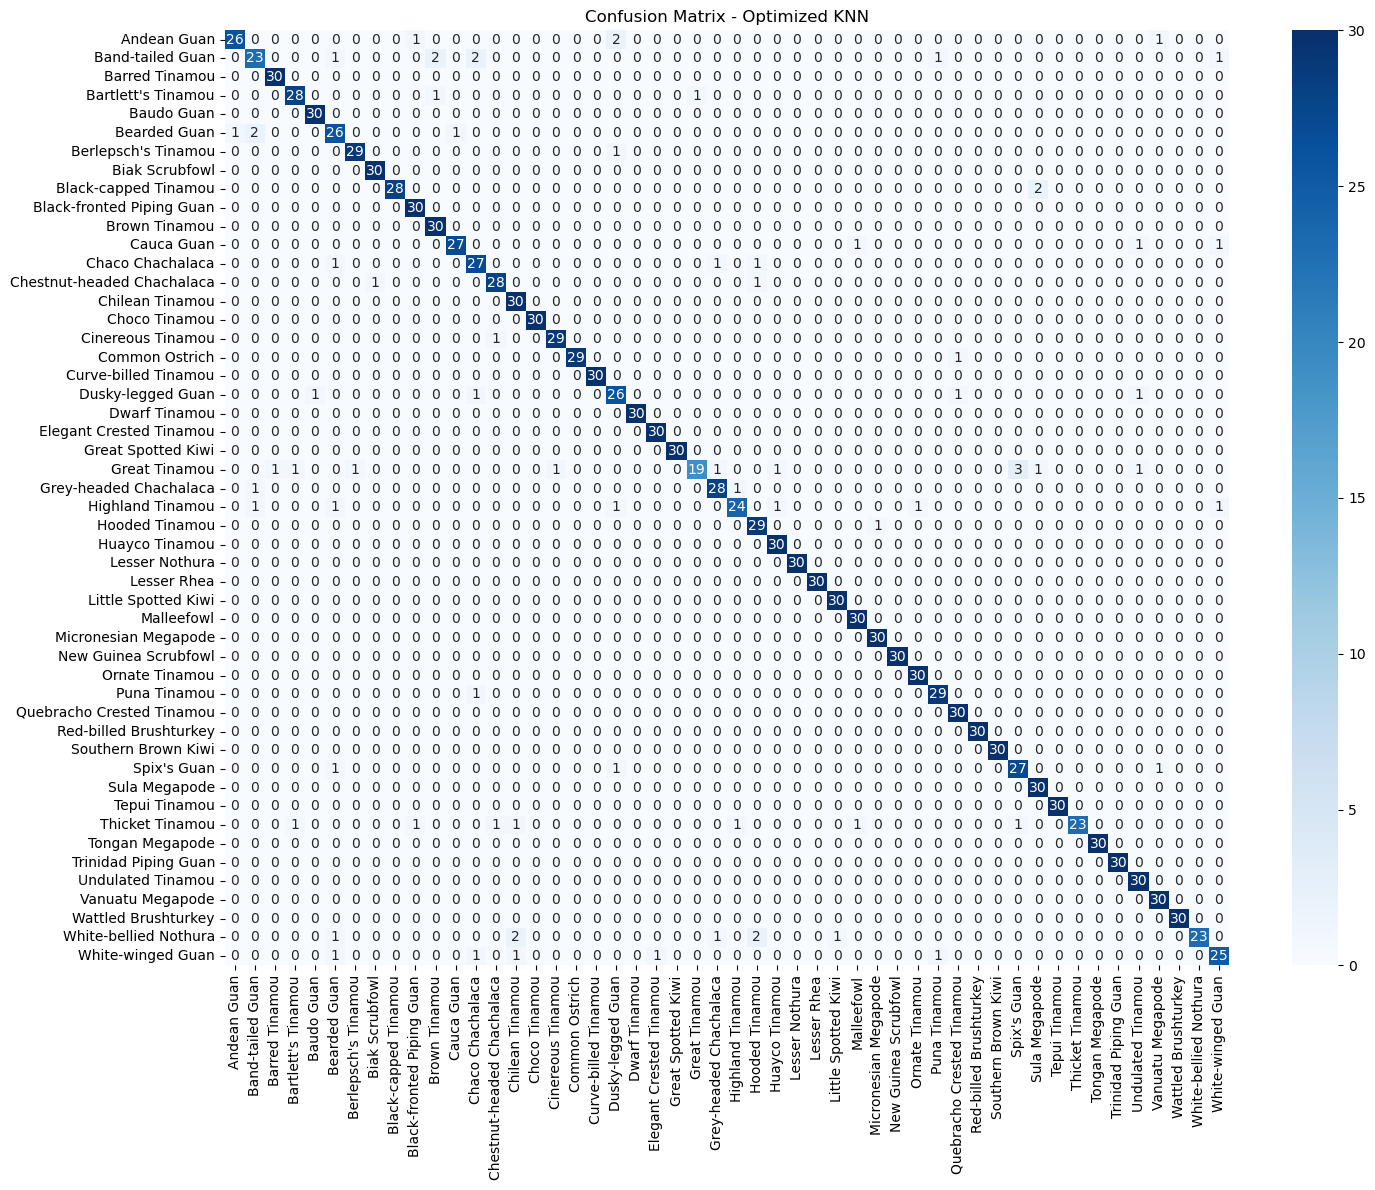

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            precision_recall_fscore_support, accuracy_score,
                            balanced_accuracy_score, matthews_corrcoef,
                            cohen_kappa_score)
from sklearn.utils.class_weight import compute_class_weight
from pathlib import Path
import json
import os
import joblib

# Configuration (same as original)
BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
FEATURES_DIR = DATA_DIR / 'features/selected_feature_TOP50/selected_features.csv'
MODEL_DIR = BASE_DIR / 'models'
METRICS_DIR = BASE_DIR / 'metrics'

# Create directories if they don't exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

# timing helper
def print_time(label, start_time):
    print(f"{label} took {time.time() - start_time:.2f} seconds.")

def evaluate_model_knn(clf, X_test, y_test, label_encoder):
    """Enhanced evaluation function with comprehensive metrics for KNN"""
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    
    # Convert to one-hot for multiclass metrics
    y_onehot = np.zeros((y_test.size, y_test.max()+1))
    y_onehot[np.arange(y_test.size), y_test] = 1
    
    # Calculate all metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'matthews_corrcoef': matthews_corrcoef(y_test, y_pred),
        'cohen_kappa': cohen_kappa_score(y_test, y_pred),
        'auc_ovr': roc_auc_score(y_onehot, y_pred_proba, multi_class='ovr'),
        'auc_ovo': roc_auc_score(y_onehot, y_pred_proba, multi_class='ovo'),
    }
    
    # Add per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    metrics['per_class'] = {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'support': support.tolist()
    }
    
    # Weighted and macro averages
    metrics['weighted_avg'] = {
        'precision': precision_recall_fscore_support(y_test, y_pred, average='weighted')[0],
        'recall': precision_recall_fscore_support(y_test, y_pred, average='weighted')[1],
        'f1': precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]
    }
    
    metrics['macro_avg'] = {
        'precision': precision_recall_fscore_support(y_test, y_pred, average='macro')[0],
        'recall': precision_recall_fscore_support(y_test, y_pred, average='macro')[1],
        'f1': precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
    }
    
    # Save metrics to JSON file
    metrics_file = METRICS_DIR / 'evaluation_metrics_KNN.json'
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Print summary metrics
    print("\nEvaluation Metrics Summary:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"Matthews Correlation: {metrics['matthews_corrcoef']:.4f}")
    print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    print(f"AUC (OvR): {metrics['auc_ovr']:.4f}")
    print(f"AUC (OvO): {metrics['auc_ovo']:.4f}")
    print(f"Weighted Avg F1: {metrics['weighted_avg']['f1']:.4f}")
    print(f"Macro Avg F1: {metrics['macro_avg']['f1']:.4f}")
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title("Confusion Matrix - Optimized KNN")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(METRICS_DIR / 'confusion_matrix_KNN.png', dpi=300)
    plt.show()
    
    return metrics

if __name__ == "__main__":
    # Load the extracted features CSV
    start = time.time()
    features_df = pd.read_csv(FEATURES_DIR)
    print_time("Data loading", start)

    # Drop non-feature columns
    start = time.time()
    non_feature_cols = ['species', 'call_type', 'filename']
    X = features_df.drop(columns=non_feature_cols)
    y = features_df['species']

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print_time("Feature preprocessing", start)

    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, 
        test_size=0.3, 
        random_state=42, 
        stratify=y_encoded
    )

    # Optimized KNN training with hyperparameter tuning
    start = time.time()
    
    # Parameter grid for optimization
    param_grid = {
        'n_neighbors': range(3, 21, 2),  # Test odd numbers from 3 to 19
        'weights': ['uniform', 'distance'],
        'p': [1, 2],  # 1: Manhattan, 2: Euclidean
        'algorithm': ['auto', 'ball_tree', 'kd_tree'],
        'leaf_size': [10, 20, 30, 40, 50]
    }
    
    # Base KNN model
    base_knn = KNeighborsClassifier()
    
    # Use stratified k-fold for cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Grid search with balanced accuracy scoring
    grid_search = GridSearchCV(
        estimator=base_knn,
        param_grid=param_grid,
        cv=cv,
        scoring='balanced_accuracy',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator
    knn_clf = grid_search.best_estimator_
    
    print("\nBest KNN parameters found:")
    print(grid_search.best_params_)
    print_time("KNN training with hyperparameter tuning", start)

    # Save the trained model
    model_file = MODEL_DIR / 'optimized_KNN_model.pkl'
    joblib.dump(knn_clf, model_file)
    print(f"\nModel saved to {model_file}")
    
    # Save the trained model AND label encoder as a package
    joblib.dump({
        'model': knn_clf,
        'label_encoder': label_encoder,
        'scaler': scaler,
        'best_params': grid_search.best_params_
    }, MODEL_DIR / 'knn_model_package.pkl')
    
    print(f"\nModel package saved to {MODEL_DIR / 'knn_model_package.pkl'}")

    # Evaluate with comprehensive metrics
    print("\nEvaluating Optimized KNN Model:")
    metrics = evaluate_model_knn(knn_clf, X_test, y_test, label_encoder)